# 다음에 볼 영화 예측하기

|평가문항|상세기준|
|---|---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# 라이브러리 및 패키지 불러오기

In [1]:
import datetime as dt
import datetime
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

# 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 데이터의 전처리

In [3]:
print(data['UserId'].nunique())
print(data['ItemId'].nunique())
print(data['Rating'].nunique())  # 1 ~ 5
print(data['Time'].nunique())

6040
3706
5
458455


* UserID는 명확한 1회 세션의 SessionID를 포함하지 않고 있음
* UserID가 SessionID의 역할을 해야 함.

## SessionId
* SessionId를 만든다. 
* UserId는 고유한 값이므로 SessionId와는 다름. 
* Session은 중복될 수 있으며 User가 여러개를 만들 수도 있음.

In [4]:
data.groupby(['UserId','Time'])['ItemId'].count()

UserId  Time     
1       978300019    1
        978300055    3
        978300103    1
        978300172    1
        978300275    1
                    ..
6040    997454398    1
        997454429    1
        997454464    2
        997454486    1
        998315055    1
Name: ItemId, Length: 471163, dtype: int64

* 고유한 UserId 별로 각각의 시간대와 ItemId의 수를 보여준다. 이것을 다음과 같이 reset_index()해서 적용

In [5]:
data_ = data.groupby(['UserId','Time'])['ItemId'].count().reset_index()
data_

,UserId,Time,ItemId
0,1,978300019,1
1,1,978300055,3
2,1,978300103,1
3,1,978300172,1
4,1,978300275,1
...,...,...,...
471158,6040,997454398,1
471159,6040,997454429,1
471160,6040,997454464,2
471161,6040,997454486,1


In [6]:
data_.reset_index(inplace=True)
data_

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


* 다시 reset_index()를 적용해서 index를 생성
* data_에 새 index를 적용한 columns을 생성하였다.
* 새로운 index는 __SessionId__가 된다. 

In [7]:
df = pd.merge(data, data_, how='inner', on=['UserId','Time'])
df

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159,1
1000205,6040,1921,4,997454464,471160,2
1000206,6040,1784,3,997454464,471160,2
1000207,6040,161,3,997454486,471161,1


* data와 data_를 하나의 df로 merge할 때 UserId와 Time을 기준으로 합친다.
 * on은 데이터를 merge할 때 겹치는 값

In [8]:
df.drop(columns='ItemId_y', inplace=True)
df

,UserId,ItemId_x,Rating,Time,index
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [9]:
df.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
df

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


* 불필요한 ItemId_y는 삭제하고 index를 보기좋게 SessionId로 변환

## Session length

In [10]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지 확인
session_length = df.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [11]:
print('중앙값 :', session_length.median()) 
print('평균값 :', session_length.mean())
print('최소값 :', session_length.min())
print('최대값 :', session_length.max())
print('백분위수 :', session_length.quantile(0.999))

중앙값 : 2.0
평균값 : 2.1228513274599234
최소값 : 1
최대값 : 30
백분위수 : 10.0


* 각 session의 길이는 2
* 99.9% 세션은 길이가 10이하
* 길이가 최대 30인 session이 존재
 * 앞의 노드에서의 예시와는 다르게 한명의 UserId가 만든 여러개의 세션이 아주 많이 존재하지 않았음.

In [42]:
long_session = session_length[session_length==28].index[0]
df[df['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112250,731,2054,4,975527781,55112
112251,731,2,5,975527781,55112
112252,731,2087,5,975527781,55112
112253,731,788,4,975527781,55112
112254,731,1654,5,975527781,55112
112255,731,247,4,975527781,55112
112256,731,260,3,975527781,55112
112257,731,2100,5,975527781,55112
112258,731,2105,4,975527781,55112
112259,731,653,4,975527781,55112


* UserId 731은 같은 Time에 여러 Item을 누르고 있음. 이것은 어떻게 가능할까?

In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

print(length_percent_cumsum)

1     0.480048
2     0.713936
3     0.847350
4     0.919684
5     0.958639
6     0.979132
7     0.989772
8     0.994989
9     0.997604
10    0.999007
11    0.999232
12    0.999408
13    0.999588
14    0.999690
15    0.999771
16    0.999832
17    0.999866
18    0.999894
19    0.999913
20    0.999943
21    0.999955
22    0.999970
23    0.999981
25    0.999985
26    0.999989
27    0.999994
28    0.999998
30    1.000000
dtype: float64


In [14]:
print(length_percent_cumsum_999)

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64


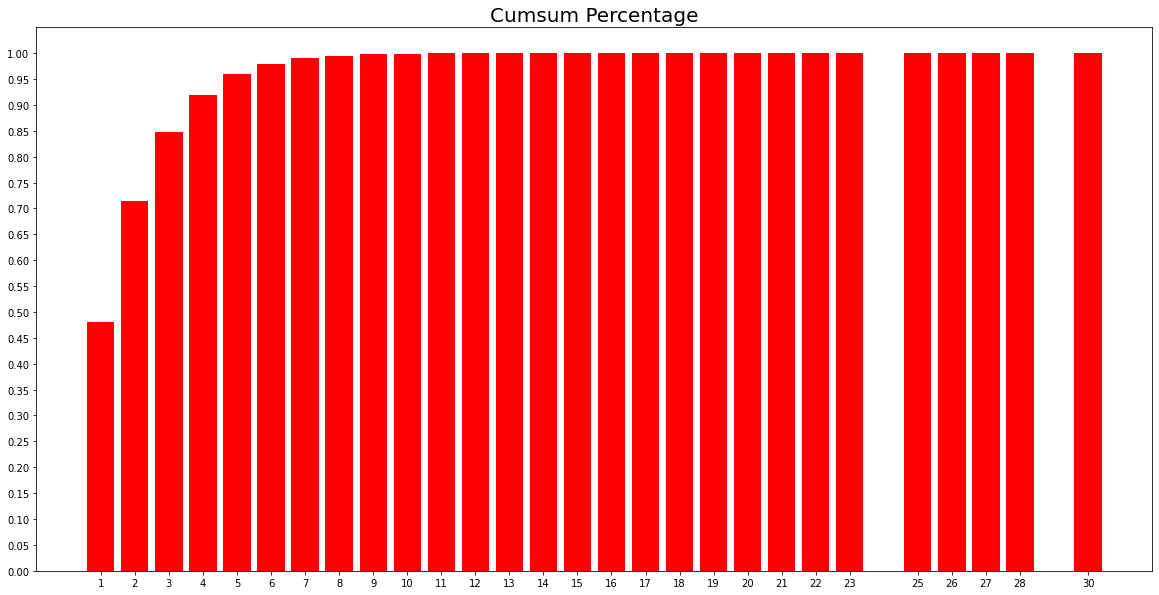

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='red')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

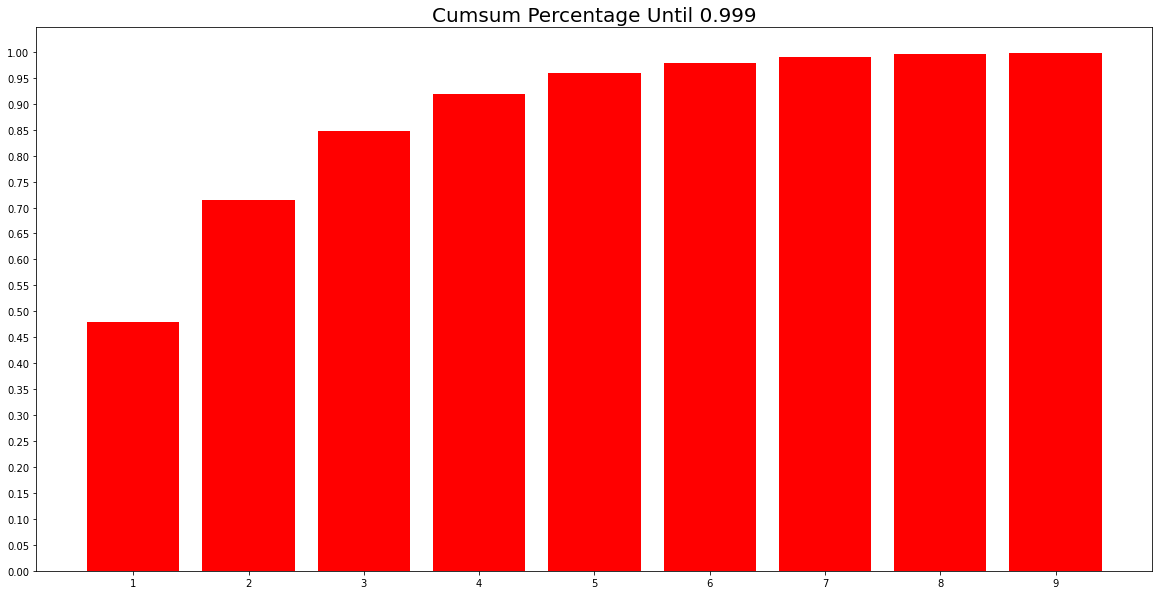

In [16]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

* length_percent_cumsum : session_length 크기의 누적합 / session_length의 합
 * sumsum() 배열에서 주어진 축에 따라 누적되는 원소들의 누적 합을 계산하는 함수.
* length_percent_cumsum_999 : session_length 기준 99.9%까지의 분포 누적합


* session에서 그룹별로 누적합을 시각화하여 확인.
 * length_percent_cumsum으로 확인할 때는 1-30까지 중 8-30까지는 99% 이상
 * 24, 29는 그룹화가 되지않았음(이 구간은 없음) 
 * length_percent_cumsum_999으로 그룹이 9개로 나눠지고 30개일 때 보다 명확하게 구분 가능

## Session Time

In [17]:
oldest, latest = df['Time'].min(), df['Time'].max()
print(oldest) 
print(latest)
print(type(latest))

956703932
1046454590
<class 'numpy.int64'>


* UTC Time을 알아보기 좋게 변환해야 함.

In [18]:
dt.date.fromtimestamp(oldest) 

datetime.date(2000, 4, 25)

In [19]:
dt.date.fromtimestamp(latest)

datetime.date(2003, 2, 28)

* 데이터는 총 3년치 들어가 있다.
* 3년치의 데이터를 어떻게 처리해야할까?
 * 길이가 너무 짧은 session은 지워야할까?
   * 예측이 어려울 수도 있다고 하여 기존 노드대로 1인 것들만 지워보자
 * 반대로 한 User가 동시간대에 여러개의 ItemId을 검색한 것도 지워야 할까?
   * 당연히 지워야 된다고 생각되지만 우선은 넣어보자

## Cleaning

In [20]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(df: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(df)
        df = cleanse_short_session(df, shortest)
        df = cleanse_unpopular_item(df, least_click)
        after_len = len(df)
        if before_len == after_len:
            break
    return df


def cleanse_short_session(df: pd.DataFrame, shortest):
    session_len = df.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    df = df[df['SessionId'].isin(session_use)]
    return df


def cleanse_unpopular_item(df: pd.DataFrame, least_click):
    item_popular = df.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    df = df[df['ItemId'].isin(item_use)]
    return df

In [21]:
df = cleanse_recursive(df, shortest=2, least_click=5)
df

,UserId,ItemId,Rating,Time,SessionId
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
7,1,2804,5,978300719,5
8,1,1207,4,978300719,5
...,...,...,...,...,...
1000189,6040,3362,4,997453796,471145
1000190,6040,3421,3,997453909,471146
1000191,6040,1258,4,997453909,471146
1000205,6040,1921,4,997454464,471160


# 미니 배치 구성
* UTC 시간으로 되어있기 때문에 이를 변환하지 않으면 dt.timedelta가 동작하지 않는다.
 * 기존의 timedelta는 빼야한다. "-" 연산자를 지원하지 않기 때문이다.
 * timedelta에 1을 넣으면 1day로 되기때문에 1일을 빼주는 것이다.
   * groupby된 SessionId의 최대시간 < 시간의 최대값 - (86400 * 1)
 * 그래서 UTC시간에서 1일(하루)이란 86,400초라서 1일을 빼려면 86400*1을 해야한다.

## 데이터 나누기

In [22]:
def split_by_date(df: pd.DataFrame, n_days: int):
    final_time = df['Time'].max()
    print(final_time)
    session_last_time = df.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = df[df['SessionId'].isin(session_in_train)]
    after_date = df[df['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [23]:
tr, test = split_by_date(df, n_days=60)
tr, val = split_by_date(tr, n_days=60)

1046454548
1041266615


* 노드에서 설명하는 추천시스템은 짧은 기간안에 소비 패턴이 변한다고 하여 1달로 나누었다.
* 조금 넉넉하게 2달로 잡고 60일씩 나누었다.
 * train(test, val을 제외한 나머지) / val(60일) / test(60일)

In [24]:
def stats_info(df: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(df)}\n'
          f'\t Sessions: {df["SessionId"].nunique()}\n'
          f'\t Items: {df["ItemId"].nunique()}\n'
          f'\t before First Time : {df["Time"].min()}\n'
          f'\t before Last Time : {df["Time"].max()}\n'
          f'\t ------------------------------- \n'
          f'\t after First Time : {dt.date.fromtimestamp(df["Time"].min())}\n'
          f'\t after Last Time : {dt.date.fromtimestamp(df["Time"].max())}\n')

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 770095
	 Sessions: 243624
	 Items: 3333
	 before First Time : 956703954
	 before Last Time : 1036081988
	 ------------------------------- 
	 after First Time : 2000-04-25
	 after Last Time : 2002-10-31

* valid Set Stats Info
	 Events: 1459
	 Sessions: 570
	 Items: 956
	 before First Time : 1036119379
	 before Last Time : 1041266615
	 ------------------------------- 
	 after First Time : 2002-11-01
	 after Last Time : 2002-12-30

* test Set Stats Info
	 Events: 1681
	 Sessions: 622
	 Items: 1061
	 before First Time : 1041277225
	 before Last Time : 1046454548
	 ------------------------------- 
	 after First Time : 2002-12-30
	 after Last Time : 2003-02-28



* before는 모델에 실질적으로 들어갈 UTC 시간
* after는 UTC 시간을 보기좋게 변환
 * train set은 2000-2003
 * val / test set은 전체 데이터셋의 마지막 2달부분

In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df_, id2idx):
    df_['item_idx'] = df_['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df_

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## SessionDataset

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

* 데이터가 주어지면 session이 시작되는 index를 담는 값과 session을 새로 indexing한 값을 갖는 클래스 만들기
 * click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
 * session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,978300055,1,0
2,1,1721,4,978300055,1,1
3,1,1022,5,978300055,1,2
7,1,2804,5,978300719,5,3
8,1,1207,4,978300719,5,4
9,1,1193,5,978300760,6,5
10,1,720,3,978300760,6,6
11,1,260,4,978300760,6,7
19,1,1035,5,978301753,14,8
20,1,1962,4,978301753,14,9


In [30]:
print(tr_dataset.click_offsets)
print(tr_dataset.session_idx)

[     0      3      5 ... 770091 770093 770095]
[     0      1      2 ... 243621 243622 243623]


## SessionDataLoader

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,978300055,1,0
2,1,1721,4,978300055,1,1
3,1,1022,5,978300055,1,2
7,1,2804,5,978300719,5,3
8,1,1207,4,978300719,5,4
9,1,1193,5,978300760,6,5
10,1,720,3,978300760,6,6
11,1,260,4,978300760,6,7
19,1,1035,5,978301753,14,8
20,1,1962,4,978301753,14,9


In [33]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


# 모델 구성

## Evaluation Metric
* 다음과 같은 모델 성능 평가를 위한 지표 
 * recall@k : recall의 개념 확장
   * 모델이 k개의 아이템을 제시 했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋기 때문에 기존의 recall에서 확장된 지표를 만듦.
 * mrr@k
   * 정답 아이템이 나온 순번의 역수 값
   * 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표 상승
   * 정답 아이템이 추천 결과 뒤쪽 혹은 안나오면 지표 하락

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Evaluation Metric

* 모델 설명 기술할 것

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# Hyperparameter Setting
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
# 학습
train_model(model, args)

Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.43] 

	 - Recall@20 epoch 1: 0.098958
	 - MRR@20    epoch 1: 0.025156



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.09] 

	 - Recall@20 epoch 2: 0.173177
	 - MRR@20    epoch 2: 0.049007



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.99] 

	 - Recall@20 epoch 3: 0.179688
	 - MRR@20    epoch 3: 0.055631



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.32] 

	 - Recall@20 epoch 4: 0.190104
	 - MRR@20    epoch 4: 0.061727



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.9]  

	 - Recall@20 epoch 5: 0.195312
	 - MRR@20    epoch 5: 0.062122



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.93]

	 - Recall@20 epoch 6: 0.208333
	 - MRR@20    epoch 6: 0.065543



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.75] 

	 - Recall@20 epoch 7: 0.210938
	 - MRR@20    epoch 7: 0.065226



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.72] 

	 - Recall@20 epoch 8: 0.212240
	 - MRR@20    epoch 8: 0.066602



Train:   0%|          | 0/4113 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.86] 

	 - Recall@20 epoch 9: 0.205729
	 - MRR@20    epoch 9: 0.066407



Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

	 - Recall@20 epoch 10: 0.204427
	 - MRR@20    epoch 10: 0.066293



# 모델 테스트

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:04<00:00,  1.47it/s]

	 - Recall@20: 0.232143
	 - MRR@20: 0.096869



# 결과 및 다양한 시도
* 1차시도
 * batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20
 * Recall@20: 0.245833, MRR@20: 0.097060
* 2차시도
 * batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20
 * Recall@20: 0.255208, MRR@20: 0.104210
 * 4 epoch 이후 결과가 좋지않았음.
* 3차 시도
 * batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20
 * Recall@20: 0.250000, MRR@20: 0.100406
* 4차 시도
 * batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20
 * Recall@20: 0.226562, MRR@20: 0.094475
* 5차 시도
 * batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20
 * Recall@20: 0.232143, MRR@20: 0.096869
 

* 별도로 Rating, Session_length는 줄이거나 제거하지 않았다.
* 성능을 개선하려면 model의 hsz와 k의 정확한 의미도 고려해서 Hyperparameter와 기타 전처리 부분을 다시 손봐야 될 것 같다.  